In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer # import simple imputer
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [13]:
data =pd.read_csv("../Data/final/Anuradapura_demand.csv",index_col="Month",parse_dates=["Month"])
data.head()

,Demand,Temp_Avg,Temp_Max,Temp_Min,Rainfall_Avg,HumidityDay,HumidityNight
Month,,,,,,,
2015-01-01,13.355776,26.7,31.3,22.2,15.8,69,92.0
2015-02-01,12.717279,26.8,31.2,22.3,129.8,71,92.0
2015-03-01,13.780719,28.7,33.6,23.7,26.0,64,89.0
2015-04-01,14.926229,29.2,34.1,24.2,288.2,68,91.0
2015-05-01,15.463069,29.3,33.5,25.1,264.7,73,91.0


In [14]:
data=data[["Demand"]]
print(data.shape)
data.head

(84, 1)


<bound method NDFrame.head of                Demand
Month                
2015-01-01  13.355776
2015-02-01  12.717279
2015-03-01  13.780719
2015-04-01  14.926229
2015-05-01  15.463069
...               ...
2021-08-01  20.739739
2021-09-01  21.633316
2021-10-01  21.214337
2021-11-01  20.385244
2021-12-01  20.907689

[84 rows x 1 columns]>

In [15]:
print(data.shape)
print(data.info())

(84, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2015-01-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Demand  84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB
None


In [16]:
data.isnull().sum() #return true/ false. If ture , its a missing place. If false, it contains a values.

Demand    0
dtype: int64

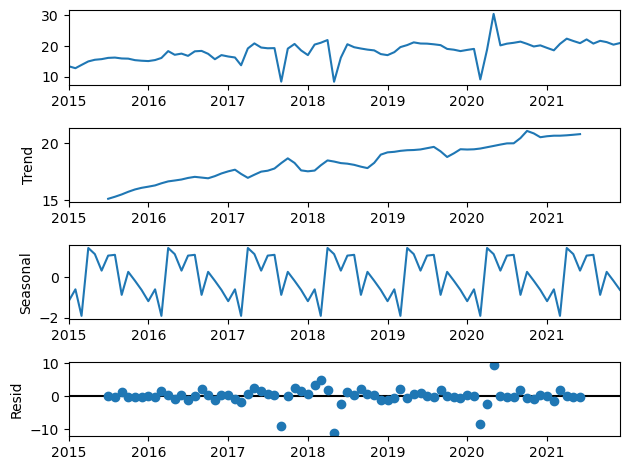

In [17]:
decompose_data=seasonal_decompose(data,model="additive")
decompose_data.plot();


<AxesSubplot:xlabel='Month', ylabel='Demand'>

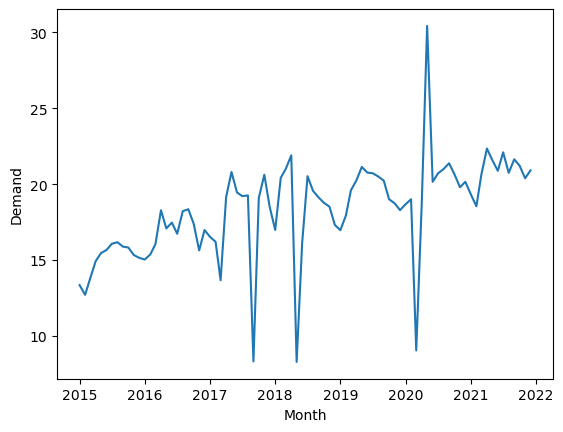

In [35]:
sns.lineplot(data=data,x=data.index,y=data.Demand)

In [59]:
data['rollMean']=data.Demand.rolling(window=12).mean()
data['rollStd']=data.Demand.rolling(window=12).std()

<AxesSubplot:xlabel='Month', ylabel='Demand'>

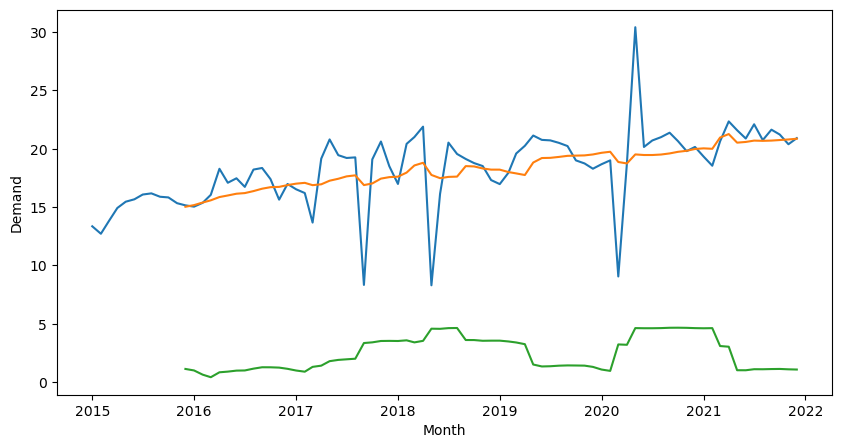

In [60]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data,x=data.index,y=data.Demand)
sns.lineplot(data=data,x=data.index,y=data.rollMean)
sns.lineplot(data=data,x=data.index,y=data.rollStd)

In [18]:
#H0:it is not stationary
#H1:it is stationary

from statsmodels.tsa.stattools import adfuller

def adfuller_test(Demand):
    result=adfuller(Demand)
    labels=['ADF test statistics','p-values','lags used','number of observations used']
    for value,lable in zip(result,labels):
        print(lable+ ' : ' +str(value))
    if result[1] <= 0.05:
        print("strong evedence against the null hypothesis,rehject the null hypothesis.Its stationary")
    else:
        print("weak evidence aginst for null hypothesis,indicating it's not stationary")

In [19]:
adfuller_test(data['Demand'])

ADF test statistics : -1.1119295014960004
p-values : 0.7102911867445969
lags used : 9
number of observations used : 74
weak evidence aginst for null hypothesis,indicating it's not stationary


In [62]:
data["shift"] =data['Demand']- data['Demand'].shift(1) 
# data["Electricty seasonal demand first difference"] =data['Demand']- data['Demand'].shift(12)  because of seasonality


In [64]:
adfuller_test(data['shift'].dropna())

ADF test statistics : -6.033009049162687
p-values : 1.4033258681841313e-07
lags used : 8
number of observations used : 74
strong evedence against the null hypothesis,rehject the null hypothesis.Its stationary


C:\Users\Shani\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


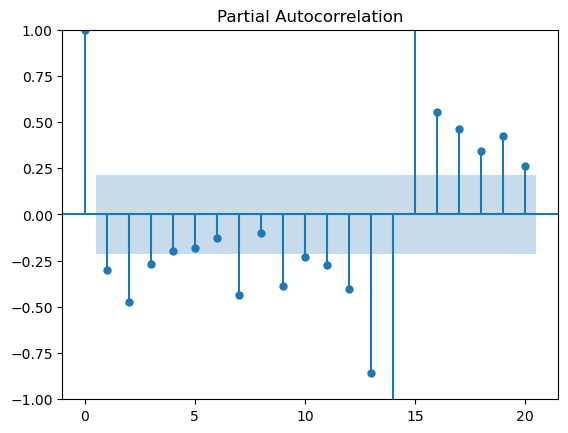

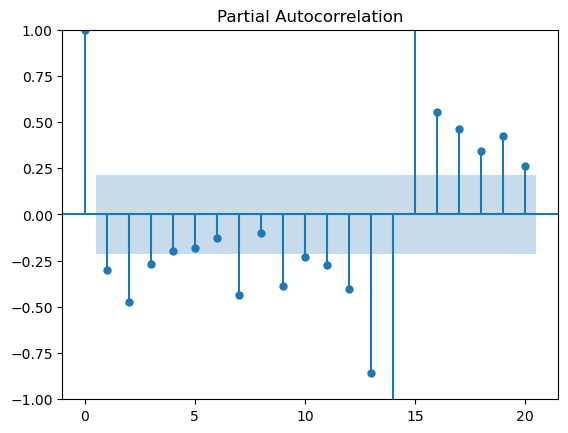

In [68]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

plot_pacf(data['shift'].dropna(),lags=20)

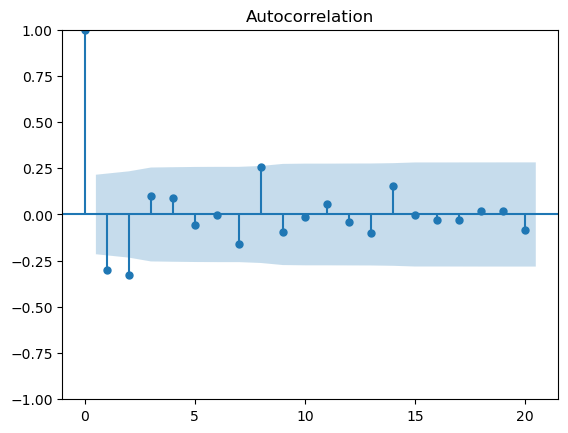

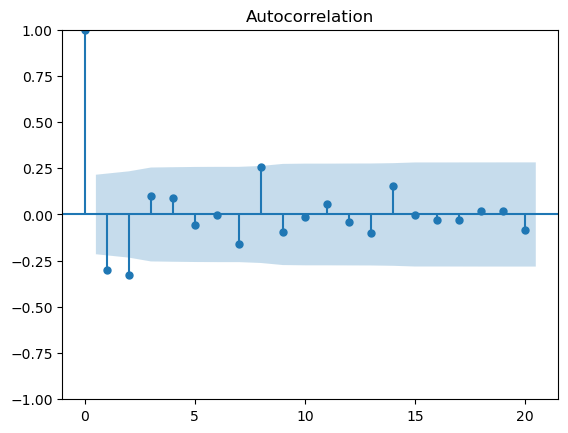

In [69]:
plot_acf(data['shift'].dropna(),lags=20)

In [77]:
#p=1,2,d=1,q=1
from statsmodels.tsa.arima.model import ARIMA
data=data.drop(columns=['rollMean','rollStd'])

In [80]:
train =data[:round(len(data)*80/100)]
test =data[round(len(data)*80/100):]
test.head()


,Demand,shift
Month,,
2020-08-01,20.989898,0.281490
2020-09-01,21.372954,0.383056
2020-10-01,20.650768,-0.722186
2020-11-01,19.794801,-0.855967
2020-12-01,20.153370,0.358569


In [86]:
ARIMA_model=ARIMA(data['Demand'],order=(1,1,1))
ArimaModel_fit=ARIMA_model.fit()
prediction=ArimaModel_fit.predict(start=test.index[0],end=test.index[-1])
data['prediction']=prediction
data.tail(12)

C:\Users\Shani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Demand,shift,prediction
Month,,,
2021-01-01,19.324695,-0.828675,20.026702
2021-02-01,18.543998,-0.780697,19.844885
2021-03-01,20.638740,2.094742,19.604941
2021-04-01,22.340633,1.701893,19.985023
2021-05-01,21.584340,-0.756293,20.456534
2021-06-01,20.875111,-0.709229,20.480447
2021-07-01,22.094731,1.219620,20.431702
2021-08-01,20.739739,-1.354992,20.766909
2021-09-01,21.633316,0.893577,20.589922


<AxesSubplot:xlabel='Month', ylabel='Demand'>

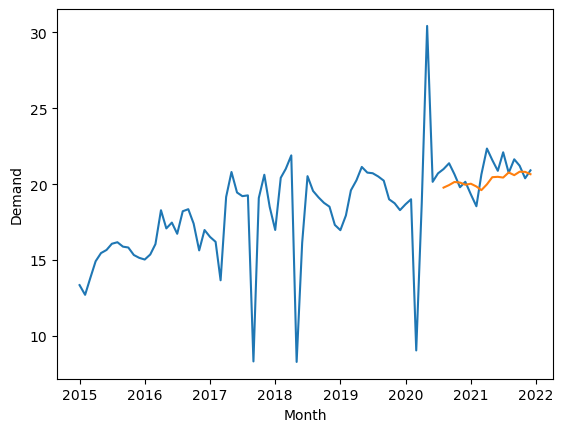

In [87]:
sns.lineplot(data=data,x=data.index,y='Demand')
sns.lineplot(data=data,x=data.index,y='prediction')

In [88]:
np.sqrt(mean_squared_error(test['Demand'],prediction))

1.0410324360453191

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [91]:
SARIMA_model=SARIMAX(train['Demand'],order=(1,1,1),seasonal_order=(1,1,1,12))
SarimaModel_fit=SARIMA_model.fit()
prediction=SarimaModel_fit.predict(start=test.index[0],end=test.index[-1])
data['prediction']=prediction

C:\Users\Shani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [92]:
data.tail()

,Demand,shift,prediction
Month,,,
2021-08-01,20.739739,-1.354992,22.497947
2021-09-01,21.633316,0.893577,20.172563
2021-10-01,21.214337,-0.418979,21.783563
2021-11-01,20.385244,-0.829093,21.533322
2021-12-01,20.907689,0.522445,21.005679


<AxesSubplot:xlabel='Month', ylabel='Demand'>

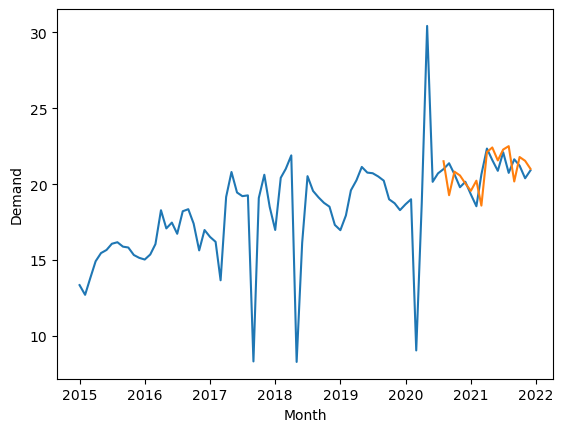

In [93]:
sns.lineplot(data=data,x=data.index,y='Demand')
sns.lineplot(data=data,x=data.index,y='prediction')

In [94]:
np.sqrt(mean_squared_error(test['Demand'],prediction))

1.0990549176120787